In [1]:
import pandas as pd

df = pd.read_csv('2019-hrs.csv')

In [2]:
df.head()

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,...,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
0,1,Fernando Abad*\abadfe01,33,SFG,NL,18,0,0,0,0,...,NaN,NaN,NaN,0,0,0,0,0,0,1
1,2,Jose Abreu\abreujo02,32,CHW,AL,159,693,634,85,180,...,0.503,0.834,119.0,319,24,13,0,10,4,*3D
2,3,Ronald Acuna Jr.\acunaro01,21,ATL,NL,156,715,626,127,175,...,0.518,0.883,122.0,324,8,9,0,1,4,*879
3,4,Jason Adam\adamja01,27,TOR,AL,3,0,0,0,0,...,NaN,NaN,NaN,0,0,0,0,0,0,1
4,5,Cristhian Adames#\adamecr01,27,SFG,NL,10,24,22,1,7,...,0.364,0.739,100.0,8,0,0,0,0,0,/45


In [3]:
df.shape

(11794, 30)

In [4]:
import numpy as np
year_begin = np.argwhere(df.Rk.eq(1)).reshape(-1)
np.arange(2019 - len(year_begin), 2020)[::-1]

/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


array([2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011])

In [5]:
df['year'] = None
year_begin = np.argwhere(df.Rk.eq(1)).reshape(-1)
df.loc[df.index[sorted(year_begin)], 'year'] = np.arange(2019 - len(year_begin) + 1, 2020)[::-1]
df['year'] = df.year.ffill()

In [6]:
df.groupby('year').size()

year
2012    1398
2013    1393
2014    1405
2015    1498
2016    1472
2017    1537
2018    1537
2019    1554
dtype: int64

In [7]:
df = df.groupby(['Name', 'year'], as_index=False)[['HR', 'PA']].sum()
df.head()

,Name,year,HR,PA
0,A.J. Achter\achteaj01,2015,0,0
1,A.J. Achter\achteaj01,2016,0,0
2,A.J. Burnett\burnea.01,2012,0,71
3,A.J. Burnett\burnea.01,2013,0,67
4,A.J. Burnett\burnea.01,2014,0,65


In [8]:
# df = df[df.year.lt(2019)]
df = df[df.PA.astype(int) > (3 * 67)]
df.shape

(2913, 4)

In [9]:
z = df.groupby(['Name', 'year']).size()
z[z > 1]

Series([], dtype: int64)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
players = df.Name.values.reshape((-1, 1))
encoder = OrdinalEncoder().fit(players)
df['player_id'] = encoder.transform(players).astype(int)

In [11]:
df.head()

,Name,year,HR,PA,player_id
10,A.J. Ellis\ellisaj01,2012,13,505,0
11,A.J. Ellis\ellisaj01,2013,10,448,0
12,A.J. Ellis\ellisaj01,2014,3,347,0
13,A.J. Ellis\ellisaj01,2015,7,217,0
14,A.J. Ellis\ellisaj01,2016,4,392,0


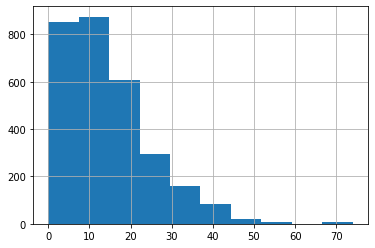

In [12]:
df.HR.hist()

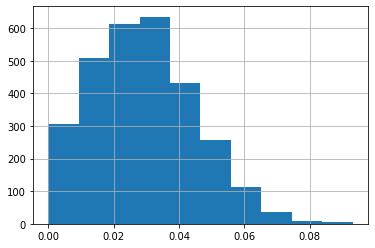

In [13]:
df.HR.div(df.PA).hist()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [juiced_ball, p, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:41<00:00, 167.43draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c336b70>,
      dtype=object)

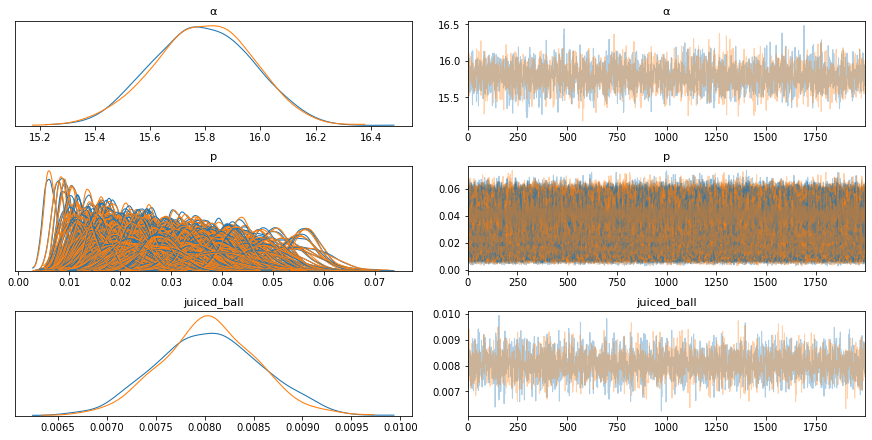

In [14]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pymc3 as pm
import theano as T

player_index = T.shared(df.player_id.values)
n_pa = T.shared(df.PA.values)
is_2019 = T.shared(df.year.eq(2019).astype(int).values)
n_players = len(encoder.categories_[0])


with pm.Model() as model:
    # Expect an average player to have around 10 home runs a season
    α = pm.Exponential('α', 1 / 10)
    
    # Interpretation of the beta-binomial distribution is α is the number of successes
    # and β is the number of failures. The interpretation here is α represents the
    # average number of home runs per 600 plate appearances.
    # See https://en.wikipedia.org/wiki/Conjugate_prior
    p = pm.Beta('p', α, 600 - α, shape=n_players)
    
    # We'll add this to the raw probability  estimated by the Beta distribution.
    # Since home run rates (per plate appearance) is typically much smaller than .1
    # we don't expect this prior to push the sampler into regions where p > 1 (even
    # though in threory p + juiced_ball could be larger than one).
    # The prior on the standard deviation is a heuristic making the conservative
    # assumption that the 2019 league total percent increase in home runs is less
    # than 1% not due to chance.
    juiced_ball = pm.HalfNormal('juiced_ball', ((6776 - 6105) / 6105) / 3)
    
    # Finally, represent the number of home runs hit by a player as a binomial
    # trial, conditioned on the number of plate appearances, the player's ability
    # and whether the 2019 juiced ball is in effect or not.
    homers = pm.Binomial('homers',
                         p=p[player_index] + is_2019 * juiced_ball,
                         n=n_pa,
                         observed=df.HR)
    

    trace = pm.sample(2000, tune=1500)

pm.traceplot(trace)

100%|██████████| 4000/4000 [00:05<00:00, 680.26it/s]


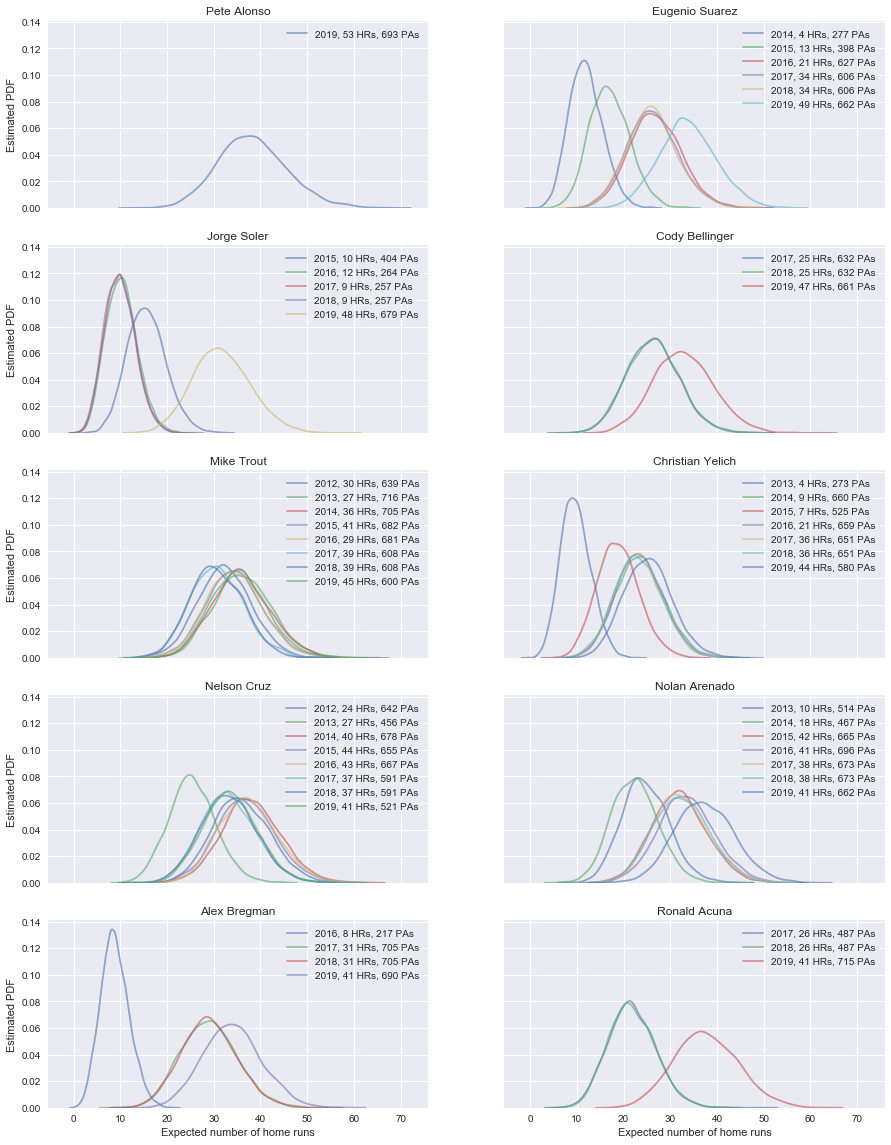

In [15]:
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import seaborn as sns


player_index.set_value(df.player_id.values)
n_pa.set_value(df.PA.values)
is_2019.set_value(df.year.eq(2019).astype(int).values)


look_at = [
    'Pete Alonso',
    'Eugenio Suarez',
    'Jorge Soler',
    'Cody Bellinger',
    'Mike Trout',
    'Christian Yelich',
    'Nelson Cruz',
    'Nolan Arenado',
    'Alex Bregman',
    'Ronald Acuna',
]

samples = pm.sample_posterior_predictive(trace, model=model)['homers']

fig, axs = plt.subplots(len(look_at) // 2, 2, figsize=(15, 20), sharex=True, sharey=True)
for player, ax in zip(look_at, axs.flat):
    player_year_index = np.argwhere(df.Name.str.startswith(player))
    for index in player_year_index:
        post_samples = samples[:, index].reshape(-1)
        df_indexed = df.iloc[index]
        year, HR, PA = df_indexed[['year', 'HR', 'PA']].iloc[0]
        sns.kdeplot(post_samples, ax=ax, alpha=0.6, label=f'{year}, {HR} HRs, {PA} PAs')
    ax.set(title=player,
           xlabel='Expected number of home runs',
           ylabel='Estimated PDF')
    ax.label_outer()
    ax.legend()

100%|██████████| 4000/4000 [00:07<00:00, 515.39it/s]


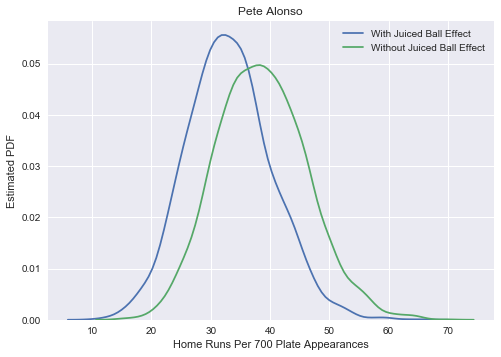

In [16]:
pete_index = df[df.Name.str.startswith('Pete Alonso')].player_id.iloc[0]

player_index.set_value(np.array([pete_index] * 2))
n_pa.set_value(np.array([700] * 2))
is_2019.set_value(np.array([0, 1]))

ppc = pm.sample_posterior_predictive(trace, model=model)

fig, ax = plt.subplots()
sns.kdeplot(ppc['homers'][:, 0], ax=ax, label='With Juiced Ball Effect')
sns.kdeplot(ppc['homers'][:, 1], ax=ax, label='Without Juiced Ball Effect')
_ = ax.set(title='Pete Alonso',
           xlabel='Home Runs Per 700 Plate Appearances',
           ylabel='Estimated PDF')

In [17]:
ppc['homers'].shape

(4000, 2)

In [18]:
import pandas as pd

df_statcast = pd.read_csv('statcast-2019-10-21.csv.gz')
df_statcast.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,CH,2018-03-29,83.5,-2.6238,5.0668,Noe Ramirez,543760,598287,single,hit_into_play_score,...,5,5,5,5,5,5,5,5,Strategic,Strategic
1,CH,2018-03-29,82.7,-2.6167,5.0671,Noe Ramirez,543760,598287,NaN,foul,...,5,5,5,5,5,5,5,5,Strategic,Strategic
2,CU,2018-03-29,77.2,-2.9329,4.8254,Noe Ramirez,543760,598287,NaN,foul,...,5,5,5,5,5,5,5,5,Strategic,Strategic
3,CU,2018-03-29,76.6,-2.8895,4.8506,Noe Ramirez,543760,598287,NaN,foul,...,5,5,5,5,5,5,5,5,Strategic,Strategic
4,CU,2018-03-29,77.8,-2.8185,4.8878,Noe Ramirez,543760,598287,NaN,ball,...,5,5,5,5,5,5,5,5,Strategic,Strategic


In [19]:
df_statcast = df_statcast[df_statcast.batter.eq(624413)]
df_statcast.shape

(2762, 89)

In [20]:
df_statcast.events.eq('home_run').sum()

53

In [21]:
hrs = df_statcast.sort_values(['game_date', 'at_bat_number', 'pitch_number']).groupby(['game_date', 'at_bat_number']).tail(1)
hrs['running_total'] = hrs.events.eq('home_run').cumsum()
hrs[['game_date', 'at_bat_number', 'running_total']]

,game_date,at_bat_number,running_total
744628,2019-03-28,2,0
743641,2019-03-28,19,0
742536,2019-03-28,39,0
741463,2019-03-28,55,0
769628,2019-03-30,2,0
...,...,...,...
1440262,2019-09-29,8,53
1439571,2019-09-29,21,53
1438521,2019-09-29,42,53
1437296,2019-09-29,61,53


100%|██████████| 4000/4000 [00:10<00:00, 397.22it/s]


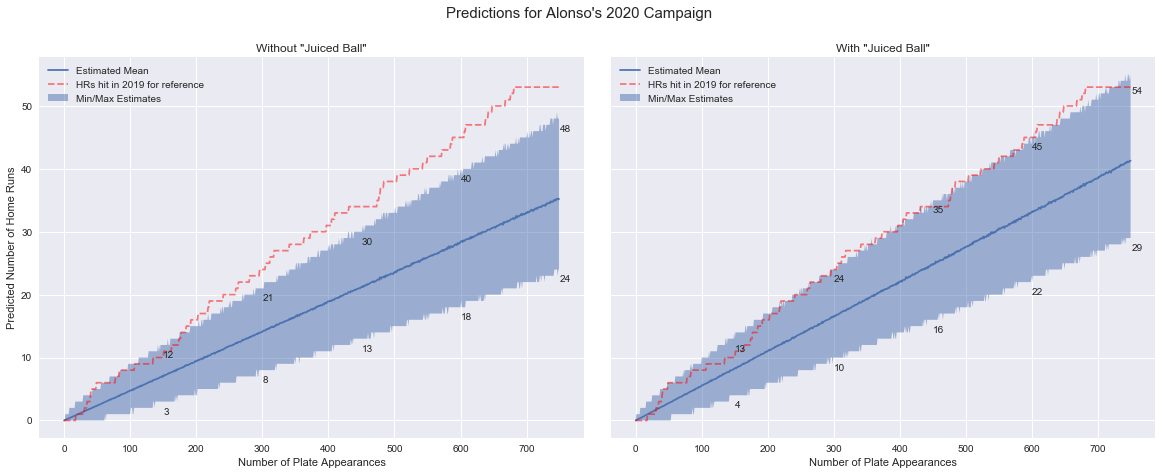

In [22]:
def annotate(ax, values, offset, skipby=150):
    for i in range(skipby, len(values), skipby):
        ax.annotate(f'{int(values[i])}', (i, values[i] + offset))
    ax.annotate(f'{int(values[-1])}', (len(values), values[-1] + offset))


def show_predictions(mean, min_, max_, reference, ax):
    n = len(mean)
    reference = np.pad(reference, (0, n - len(reference)), mode='edge')
    ax.plot(np.arange(n), mean, label='Estimated Mean')
    ax.plot(np.arange(len(reference)), reference, color='r', alpha=0.5, ls='--', label='HRs hit in 2019 for reference')
    ax.fill_between(np.arange(n), min_, max_, alpha=0.5, label='Min/Max Estimates')
    
    annotate(ax, min_, -2); annotate(ax, max_, -2)
    
    ax.legend(loc='upper left')
    ax.set(xlabel='Number of Plate Appearances', ylabel='Predicted Number of Home Runs')


def estimate_2020(with_juiced_ball, n=750):
    pete_index = df[df.Name.str.startswith('Pete Alonso')].player_id.iloc[0]
    player_index.set_value(np.array([pete_index] * n))
    n_pa.set_value(np.arange(n))
    is_2019.set_value(np.array([with_juiced_ball] * n))

    ppc = pm.sample_posterior_predictive(trace, model=model)['homers']
    mean = np.mean(ppc, axis=0)
    min_, max_ = np.quantile(ppc, [0.05, 0.95], axis=0)
    
    return mean, min_, max_

fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
plt.suptitle('Predictions for Alonso\'s 2020 Campaign', fontsize=15)
plt.subplots_adjust(wspace=0.05)

mean, min_, max_ = estimate_2020(0)
axs[0].set_title('Without "Juiced Ball"')
show_predictions(mean, min_, max_, hrs.running_total, axs[0])

mean, min_, max_ = estimate_2020(1)
axs[1].set_title('With "Juiced Ball"')
show_predictions(mean, min_, max_, hrs.running_total, axs[1])

for ax in axs: ax.label_outer()

plt.savefig('pete-alonso-2020.png')

100%|██████████| 4000/4000 [00:08<00:00, 464.88it/s]


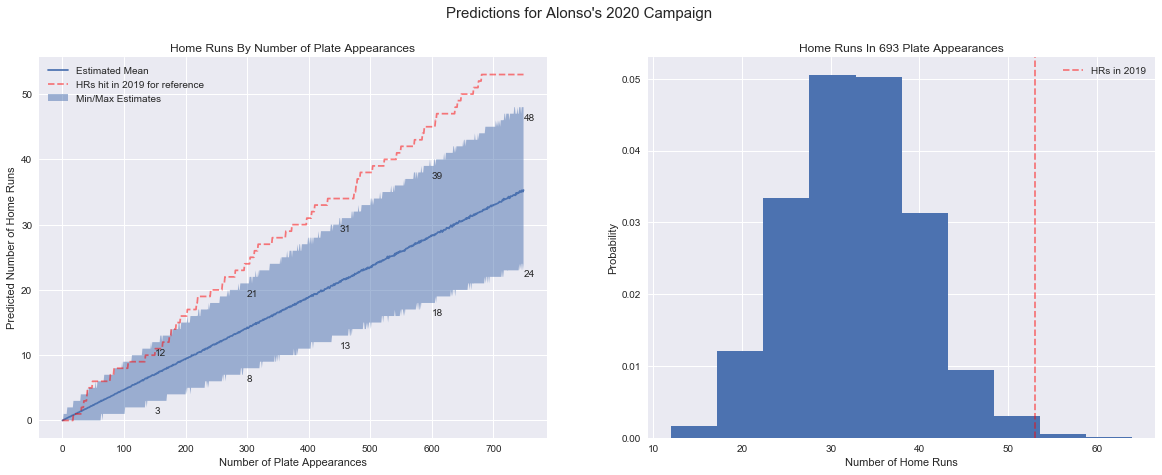

In [23]:
def marginalize_2019_effect(n=750):
    pete_index = df[df.Name.str.startswith('Pete Alonso')].player_id.iloc[0]
    player_index.set_value(np.array([pete_index] * n))
    n_pa.set_value(np.arange(n))
    is_2019.set_value(np.array([0] * n))
    ppc1 = pm.sample_posterior_predictive(trace, model=model)['homers']
    
    pete_index = df[df.Name.str.startswith('Pete Alonso')].player_id.iloc[0]
    player_index.set_value(np.array([pete_index] * n))
    n_pa.set_value(np.arange(n))
    is_2019.set_value(np.array([1] * n))
    ppc2 = pm.sample_posterior_predictive(trace, model=model)['homers']
    
    full_posterior = np.stack([ppc1, ppc1])
    mean = np.mean(full_posterior, axis=(0, 1))
    min_, max_ = np.quantile(full_posterior, [0.05, 0.95], axis=(0, 1))
    return mean, min_, max_, full_posterior


mean, min_, max_, posterior = marginalize_2019_effect()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Predictions for Alonso\'s 2020 Campaign', fontsize=15)

axs[0].set_title('Home Runs By Number of Plate Appearances')
show_predictions(mean, min_, max_, hrs.running_total, axs[0])

axs[1].set(title='Home Runs In 693 Plate Appearances',
           xlabel='Number of Home Runs',
           ylabel='Probability')
axs[1].hist(posterior[:, :, 693].reshape(-1), density=True)
axs[1].axvline(53, color='r', alpha=0.5, ls='--', label='HRs in 2019')
axs[1].legend()

plt.savefig('pete-alonso-2020-maraginalized.png')

In [24]:
def estimate_2020_season_total(with_juiced_ball, min_pa, max_pa):
    n = max_pa - min_pa + 1
    pete_index = df[df.Name.str.startswith('Pete Alonso')].player_id.iloc[0]
    player_index.set_value(np.array([pete_index] * n))
    n_pa.set_value(np.arange(min_pa, max_pa + 1))
    is_2019.set_value(np.array([with_juiced_ball] * n))

    ppc = pm.sample_posterior_predictive(trace, model=model)['homers']
    
    return ppc

ppc1 = estimate_2020_season_total(0, 675, 715)
ppc2 = estimate_2020_season_total(0, 675, 715)
np.quantile(np.stack([ppc1, ppc2]), [0.1, 0.9])

100%|██████████| 4000/4000 [00:07<00:00, 534.75it/s]


array([24., 42.])